In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import kl_div
from scipy.stats import gaussian_kde

In [12]:
num_trials = 1000  # to ensure a bit of data stability
block_side_bias_probabilities = [0.5, 0.5]
possible_trial_strengths = tuple(np.linspace(0, 2.5, 6))
possible_trial_probabilities = tuple(np.ones(6) / 6)
max_rnn_steps_per_trial = 12

trial_strengths = np.random.choice(
    possible_trial_strengths, p=possible_trial_probabilities, size=(num_trials, 1)
)

# hold trial strength constant for duration of trial
trial_strengths = np.repeat(a=trial_strengths, repeats=max_rnn_steps_per_trial, axis=1)
signal_sides_indices = np.random.choice(
    [0, 1], p=block_side_bias_probabilities, size=(num_trials, 1)
)
signal_sides_indices = np.repeat(
    signal_sides_indices, axis=-1, repeats=max_rnn_steps_per_trial
)

trial_sides = 2 * signal_sides_indices - 1

left_trials = np.argwhere(signal_sides_indices[:, 0] == 0).reshape(
    -1,
)
right_trials = np.argwhere(signal_sides_indices[:, 0] == 1).reshape(
    -1,
)

In [14]:
# OG data
signal = np.random.normal(loc=trial_strengths, scale=np.ones_like(trial_strengths))
# now generate noise
sampled_stimuli = np.random.normal(
    loc=0.0, scale=1.0, size=(num_trials, max_rnn_steps_per_trial, 2)
)
# assign to relative truth
sampled_stimuli[np.eye(2)[signal_sides_indices].astype(bool)] = (
    signal.flatten()
)  # sampled stimuli, noise with stimulus

In [15]:
# now we plot the distributions
def plot_distribution(sampled_stimuli, left_trials, right_trials):
    fig, ax = plt.subplots(figsize=(10, 4), ncols=2)

    sns.kdeplot(
        sampled_stimuli[left_trials, :, 0].reshape(
            -1,
        ),
        ax=ax[0],
        label="Left",
        color="red",
    )
    sns.kdeplot(
        sampled_stimuli[left_trials, :, 1].reshape(
            -1,
        ),
        ax=ax[0],
        label="Right",
        color="k",
    )

    sns.kdeplot(
        sampled_stimuli[right_trials, :, 0].reshape(
            -1,
        ),
        ax=ax[1],
        label="Left",
        color="red",
    )
    sns.kdeplot(
        sampled_stimuli[right_trials, :, 1].reshape(
            -1,
        ),
        ax=ax[1],
        label="Right",
        color="k",
    )
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Left sided trials")
    ax[1].set_title("Right sided trials")

In [34]:
# choice A; just increase general noise, keep the signal same

choicea = np.random.normal(
    loc=0.0, scale=2.0, size=(num_trials, max_rnn_steps_per_trial, 2)
)

# assign to relative truth
choicea[np.eye(2)[signal_sides_indices].astype(bool)] = (
    signal.flatten()
)  # sampled stimuli, noise with stimulus


# choice B; keep noise same, increase signal noise scaled by trial strength

signalb = np.random.normal(loc=trial_strengths, scale=trial_strengths)

# keep same noise level as original for the other side
choiceb = np.random.normal(
    loc=0.0, scale=1.0, size=(num_trials, max_rnn_steps_per_trial, 2)
)

# assign to relative truth
choiceb[np.eye(2)[signal_sides_indices].astype(bool)] = (
    signalb.flatten()
)  # sampled stimuli, noise with stimulus

# choice C; keep noise same, increase signal noise by a factor

signalc = np.random.normal(
    loc=trial_strengths, scale=np.ones_like(trial_strengths) * 1.5
)

choicec = np.random.normal(
    loc=0.0, scale=1.0, size=(num_trials, max_rnn_steps_per_trial, 2)
)

# assign to relative truth
choicec[np.eye(2)[signal_sides_indices].astype(bool)] = (
    signalc.flatten()
)  # sampled stimuli, noise with stimulus


# choice D
signald = np.random.normal(
    loc=trial_strengths, scale=np.ones_like(trial_strengths) * 1.25
)

# increase noise here as well
choiced = np.random.normal(
    loc=0.0, scale=1.5, size=(num_trials, max_rnn_steps_per_trial, 2)
)

# assign to relative truth
choiced[np.eye(2)[signal_sides_indices].astype(bool)] = (
    signald.flatten()
)  # sampled stimuli, noise with stimulus

# OG -> samplestimuli

In [19]:
def difference(dist1, dist2):
    kde1 = gaussian_kde(dist1, bw_method="silverman")
    kde2 = gaussian_kde(dist2, bw_method="silverman")

    # Create a range of values to evaluate the PDFs
    x_values = np.linspace(-10, 10, 1000)

    # Compute the PDFs
    pdf1 = kde1(x_values)
    pdf2 = kde2(x_values)

    # Normalize the PDFs (in case they are not normalized)
    pdf1 /= np.sum(pdf1)
    pdf2 /= np.sum(pdf2)

    # Compute KL Divergence (P || Q)
    kl_divergence = np.sum(kl_div(pdf1, pdf2))

    # Estimate the mean and std of the KDEs
    mean1 = np.sum(x_values * pdf1)
    std1 = np.sqrt(np.sum((x_values - mean1) ** 2 * pdf1))

    mean2 = np.sum(x_values * pdf2)
    std2 = np.sqrt(np.sum((x_values - mean2) ** 2 * pdf2))

    # Compute d-prime
    d_prime = (mean1 - mean2) / np.sqrt((std1**2 + std2**2) / 2)
    return kl_divergence, d_prime

In [39]:
def plot_distribtion_separated(
    stimulus_data, left_trials, right_trials, trial_strengths
):

    indices_dict_left = {}
    indices_dict_right = {}

    # Loop over each value and find its indices
    for value in np.unique(trial_strengths[left_trials, 0]):
        indices_dict_left[value] = np.where(trial_strengths[left_trials, 0] == value)[0]

    for value in np.unique(trial_strengths[right_trials, 0]):
        indices_dict_right[value] = np.where(trial_strengths[right_trials, 0] == value)[
            0
        ]

    fig, ax = plt.subplots(
        figsize=(24, 6), ncols=len(indices_dict_left), nrows=2, sharex=True, sharey=True
    )

    # top row for left trials, bottom row for right trials, similar otherwise
    # when indexing, remeber to use the correct subset

    for idx in range(2):
        for idy in range(len(indices_dict_left.keys())):

            if idx == 0:
                k = list(indices_dict_left.keys())[idy]
                ax[idx][idy].set_title(f"L-stim-strength:{k}")
                data_l = stimulus_data[left_trials, :, 0][indices_dict_left[k]].reshape(
                    -1,
                )
                data_r = stimulus_data[left_trials, :, 1][indices_dict_left[k]].reshape(
                    -1,
                )
            else:
                k = list(indices_dict_right.keys())[idy]
                ax[idx][idy].set_title(f"Ri-stim-strength:{k}")
                data_l = stimulus_data[right_trials, :, 0][
                    indices_dict_right[k]
                ].reshape(
                    -1,
                )
                data_r = stimulus_data[right_trials, :, 1][
                    indices_dict_right[k]
                ].reshape(
                    -1,
                )

            # now just plot them
            sns.kdeplot(data_l, color="red", label="left", ax=ax[idx][idy])
            sns.kdeplot(data_r, color="blue", label="right", ax=ax[idx][idy])

            # add text for KL divergence and estimated dprime
            kldivergence, dprime = difference(data_l, data_r)
            _, ymax = ax[idx, idy].get_ylim()
            xmin, _ = ax[idx, idy].get_xlim()
            ax[idx, idy].text(
                xmin + 0.1,
                ymax - 0.1,
                f"KL-div:{kldivergence:0.2f}, dprime:{np.abs(dprime):0.2f}",
            )

    plt.legend()

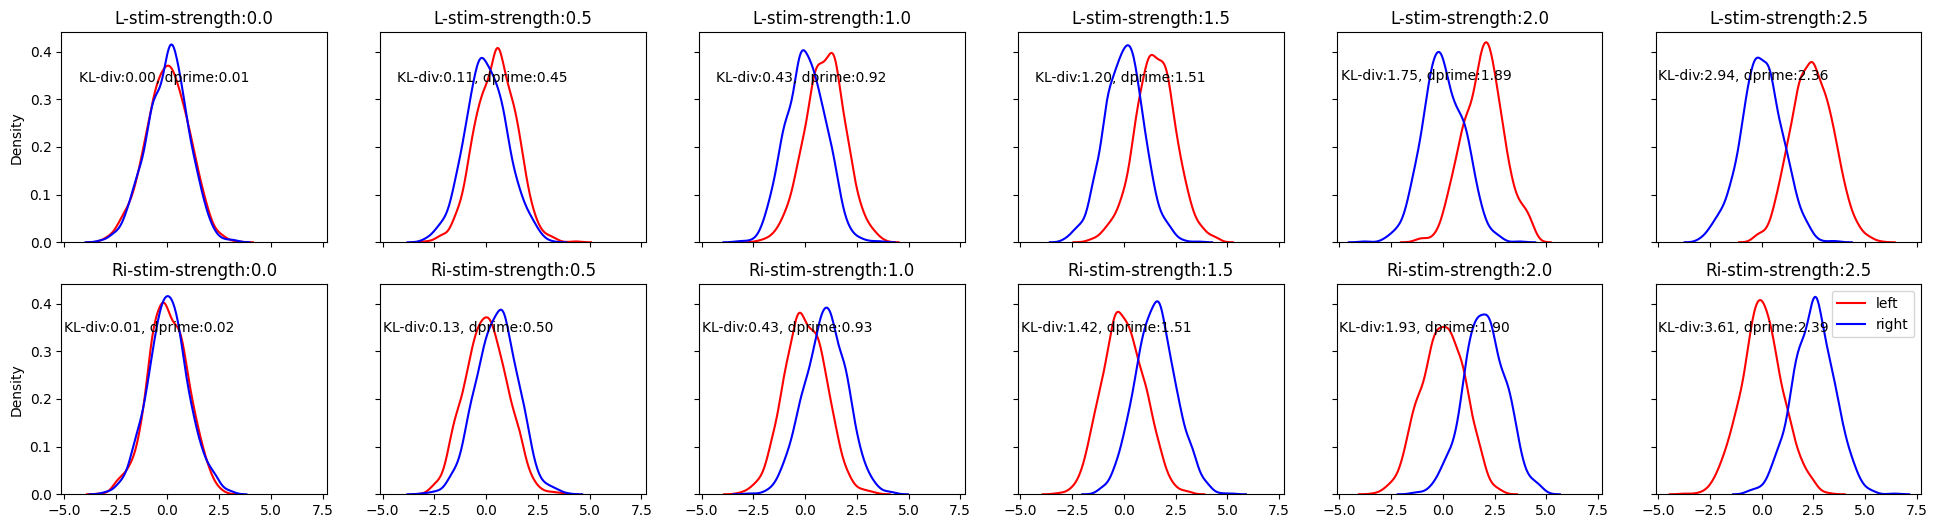

In [40]:
plot_distribtion_separated(sampled_stimuli, left_trials, right_trials, trial_strengths)

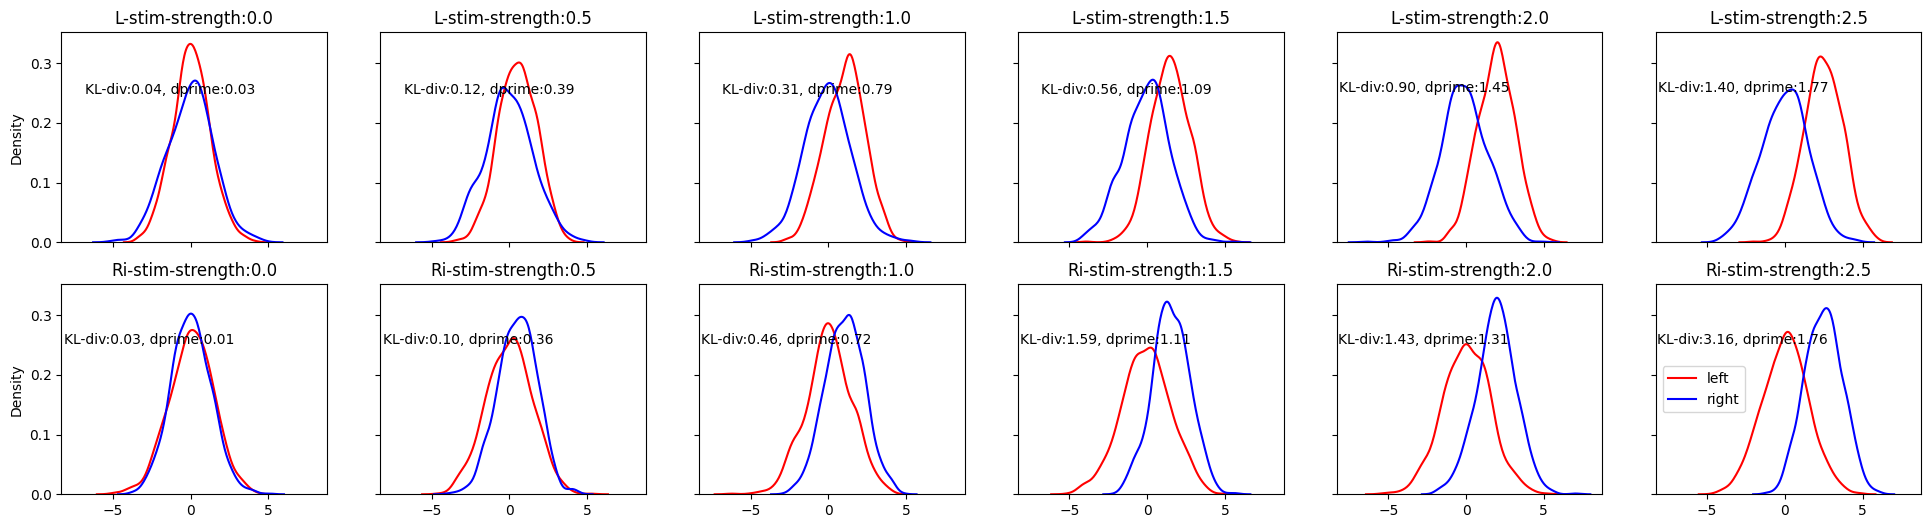

In [41]:
plot_distribtion_separated(choiced, left_trials, right_trials, trial_strengths)

In [42]:
# choose option D